In [1]:
#1 -- measurements
#2 -- algorithms (Wolff, Metropolis)
#3 -- plots!

using Random

In [2]:
module Measurements

struct Accumulator
    count::Dict{String, UInt64}
    data::Dict{String, Any}
    
    function Accumulator()
        new(Dict{String, UInt64}(), Dict{String, Any}())
    end
end

function add!(acc::Accumulator, name::String, data)
    if haskey(acc.count, name)
        acc.count[name] += 1
        acc.data[name] += data
    else
        acc.count[name] = 1
        acc.data[name] = copy(data)
    end
end
    
function mean(acc::Accumulator, name::String)
    return acc.data[name]/acc.count[name]
end


end

Main.Measurements

In [3]:
abstract type IsingModel end
abstract type Ising_1d <: IsingModel end
abstract type Ising_2d <: IsingModel end
abstract type Ising_3d <: IsingModel end

mutable struct Periodic_1d <: Ising_1d
  num_spins::Int
  state::Array{Int8, 1}
  beta::T where T <: AbstractFloat

  energy::S where S <: AbstractFloat
  average_magnetization::U where U <:AbstractFloat

  function Periodic_1d(
    ns::Int,
    beta::T,
  ) where T <: Real
    @assert ns > 0

    init = rand(Int8[-1, 1], ns)

    energy = 0.0
    @inbounds @simd for i in 1:ns
      energy += init[i] * init[i == ns ? 1 : i+1]
    end
    mag = sum(init) / ns

    new(ns, init, beta, energy, mag)
  end
end

function Hamiltonian(im::Periodic_1d)::Float64
    pair_sum = 0.0
    site_sum = im.h * sum(im.state)

    @inbounds @simd for i in 1:im.num_spins
        pair_sum += im.state[i] * im.state[i == im.num_spins ? 1 : i+1]
    end

    return (-im.beta * pair_sum) - site_sum
end

# Average Magnetization
function AvgMagnetization(im::Periodic_1d)
    return sum(im.state) / (im.num_spins)^2
end

###################################################################3
mutable struct Periodic_2d <: Ising_2d
  num_spins::Int
  state::Array{Int8, 2}
  beta::T where T <: AbstractFloat

  energy::U where U <: AbstractFloat
  average_magnetization::V where V <:AbstractFloat

  function Periodic_2d(
    ns::Int,
    beta::T,
  ) where T <: Real
    @assert ns > 0

    init = rand(Int8[-1, 1], (ns,ns))

    # TODO
    energy = 0.0
    @inbounds @simd for i in 1:ns
      @inbounds @simd for j in 1:ns
        energy += 1
      end
    end

    mag = sum(init) / (ns^2)

    new(ns, init, beta, energy, mag)
  end
end

###################################################################3
mutable struct Periodic_3d <: Ising_3d
  num_spins::Int
  state::Array{Int8, 3}
  beta::T where T <: AbstractFloat

  energy::U where U <: AbstractFloat
  average_magnetization::V where V <:AbstractFloat

  function Periodic_3d(
    ns::Int,
    beta::T,
  ) where T <: Real
    @assert ns > 0
    new(ns, rand(Int8[-1, 1], (ns, ns)), beta)
  end
end

In [10]:
# 1d Metropolis
function neighbors(im::Periodic_1d, i)
    ns = im.num_spins
    return [CartesianIndex(ifelse(i==1, ns, i-1)),
        CartesianIndex(ifelse(i==ns, 1, i+1))]
end


function dEnergy(im::Periodic_1d, i)
    @assert i > 0
    @assert im.num_spins >= i
    nbrs = neighbors(im, i)
    bond_energy = -im.state[i]*(im.state[nbrs[1]] + im.state[nbrs[2]])
            
    return bond_energy
end

function Metropolis!(im::Periodic_1d, niters::Int=Int64(1e5))
    @assert niters > 0
    ns = im.num_spins
    
    @inbounds for _ in 1:niters
        @inbounds for _ in 1:ns
            i = rand(1:ns)
            
            de = -2/im.beta * dEnergy(im, i)
            if (de <= 0 || rand() < exp(-de))
                im.state[i] *= -1
                
                im.energy += de
                im.average_magnetization += de * (im.beta / im.num_spins)
            end
        end
    end
end

Metropolis! (generic function with 2 methods)

In [11]:
# C ≈ 1 / |T - T_c|^\alpha
function solve!(
    im::T,
    acc::Measurements.Accumulator,
    nsweeps=10^3,
    ntherm=10^4, 
    meas_interval=10^2
) where {T <: Ising_1d}
    
    if mod(nsweeps, meas_interval) != 0
        error("Need nsweeps divisible by interval_meas!")
    end
    
    # thermalization steps
    Metropolis!(im, ntherm)
    
    # Measurement sweeps
    @inbounds for imeas in 1:(nsweeps/meas_interval)
        Metropolis!(im, meas_interval)
        Measurements.add!(acc, "E", Float64(im.energy))
        Measurements.add!(acc, "E2", Float64((im.energy)^2))
    end
end

solve! (generic function with 4 methods)

In [16]:
Ts_mc = range(0.4, 2, length=10)
C_mc = Float64[]
for T in Ts_mc
    imi = Periodic_1d(100, T)
    acc = Measurements.Accumulator()
    solve!(imi, acc, 10^6, 10^5, 10)
    E = Measurements.mean(acc, "E")
    E2 = Measurements.mean(acc, "E2")
    push!(C_mc, (E2 - E^2)/T^2)
end



In [14]:
Ts = range(0.1, 2, length=100)
exact_C(T) = 1/(T * cosh(1/T))^2

exact_C (generic function with 1 method)

In [ ]:
using Plots

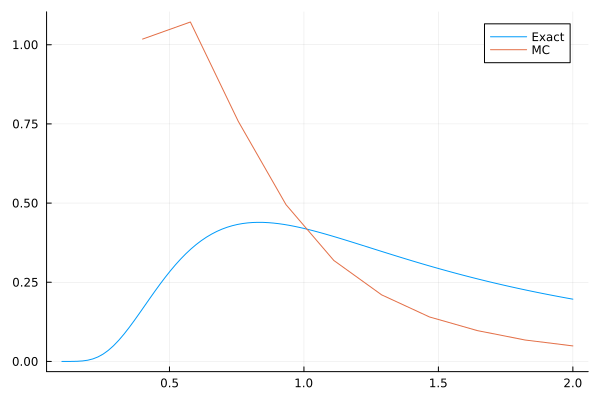

In [17]:
Plots.plot(Ts, exact_C.(Ts), label="Exact")
Plots.plot!(Ts_mc, C_mc ./ 100, label="MC")

In [ ]:
using Random

In [18]:
global const crit_2d = (2 / log(1 + sqrt(2)))

function neighbors(im::Periodic_2d, i,j)
  ns = im.num_spins
  return [CartesianIndex((ifelse(i==1, ns, i-1), j)),
    CartesianIndex((ifelse(i==ns, 1, i+1), j)),
    CartesianIndex((i, ifelse(j==1, ns, j-1))),
    CartesianIndex((i, ifelse(j==ns, 1, j+1)))]
end

function dEnergy(im::Periodic_2d, i,j)
  nbrs = neighbors(im, i,j)
  
  return -im.state[i,j]*(im.state[nbrs[1]] + im.state[nbrs[2]] + im.state[nbrs[3]] + im.state[nbrs[4]])
end


function Metropolis!(im::Periodic_2d, niters::Int=1000)
    @assert niters > 0
    
    ns = im.num_spins
    
    for _ in 1:niters
        for _ in 1:ns^2
            i = rand(1:ns)
            j = rand(1:ns)
            
            de = -2/im.beta * (dEnergy(im, i,j))
            if (de <= 0 || rand() < exp(-de))
                im.state[i,j] *= -1
                #im.energy += de / (ns^2)
                #im.magnetization += 2.0 * im.state[i,j] * im.state[ns,ns]
            end
        end
    end
    
end

Metropolis! (generic function with 4 methods)

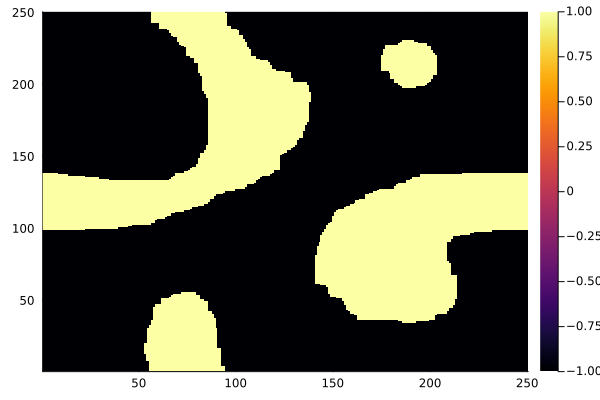

In [20]:
im2 = Periodic_2d(250, 0.00003)
Metropolis!(im2)
heatmap(im2.state)

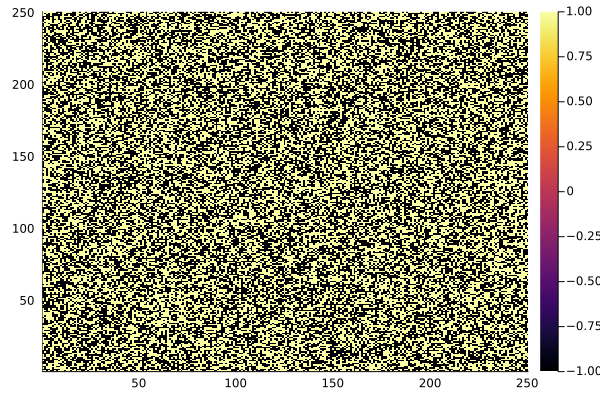

In [21]:
im2 = Periodic_2d(250, 100.0)
Metropolis!(im2)
heatmap(im2.state)

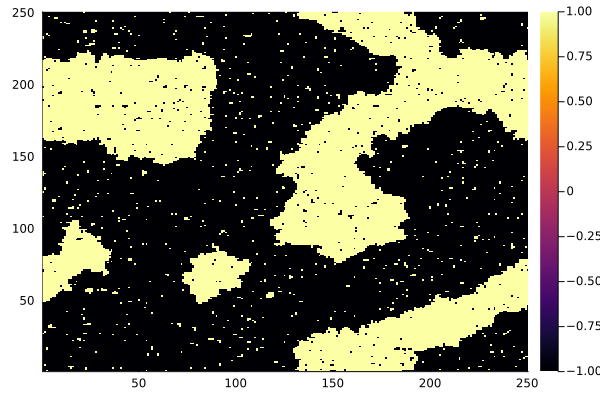

In [22]:
im2 = Periodic_2d(250, 1.8)
Metropolis!(im2)
heatmap(im2.state)

In [ ]:
Metropolis!(im2, 1)
heatmap(im2.state)

In [ ]:
crit_2d